In [1]:
import my_library.common_analysis_tools as tools
import my_library.kinematic_cuts as kcuts
import my_library.constants as constants
import ROOT
import numpy as np

Welcome to JupyROOT 6.24/04


In [2]:
ROOT.gStyle.SetOptStat(0)

In [3]:
@ROOT.Numba.Declare(['float', 'float', 'float'], 'float')
def get_theta(px, py, pz):
    return np.degrees(np.arctan2(np.sqrt(px**2 + py**2), pz))

@ROOT.Numba.Declare(['float', 'float'], 'float')
def get_phi(px, py):
    return np.degrees(np.arctan2(py, px))


In [4]:
def make_kinematics_hists(particle, df, pxmin=-2.0, pxmax=2.0, pymin=-2.0, pymax=2.0, pzmin=-2.0, pzmax=2.0, pmin=-2.0, pmax=2.0, thetamin=0.0, thetamax=180.0, bin_size_p=0.01, bin_size_theta=1.0, phi_deg_per_bin=1.0):
        n_bins_px = int((pxmax - pxmin) / bin_size_p)
        n_bins_py = int((pymax - pymin) / bin_size_p)
        n_bins_pz = int((pzmax - pzmin) / bin_size_p)
        n_bins_p = int((pmax - pmin) / bin_size_p)
        n_bins_theta = int((thetamax - thetamin) / bin_size_theta)
        n_bins_phi = int(370/phi_deg_per_bin)

        hist_px = df.Histo1D((f'{particle}_px', f'{particle}_px', n_bins_px, pxmin, pxmax), f'{particle}_px')
        hist_py = df.Histo1D((f'{particle}_py', f'{particle}_py', n_bins_py, pymin, pymax), f'{particle}_py')
        hist_pz = df.Histo1D((f'{particle}_pz', f'{particle}_pz', n_bins_pz, pzmin, pzmax), f'{particle}_pz')
        hist_p = df.Define('p', f'sqrt({particle}_px*p_px + {particle}_py*p_py + {particle}_pz*p_pz)').Histo1D((f'{particle}_p', f'{particle}_p', n_bins_p, pmin, pmax), 'p')
        hist_theta = df.Define('theta', f'Numba::get_theta({particle}_px, {particle}_py, {particle}_pz)').Histo1D((f'{particle}_theta', f'{particle}_theta', n_bins_theta, thetamin, thetamax), 'theta')
        hist_phi = df.Define('phi', f'Numba::get_phi({particle}_px, {particle}_py)').Histo1D((f'{particle}_phi', f'{particle}_phi', n_bins_phi, -185.0, 185.0), 'phi')
        return hist_px, hist_py, hist_pz, hist_p, hist_theta, hist_phi


def get_kinematics(channel: str, particle: str, df: ROOT.RDataFrame, pxmin=-2.0, pxmax=2.0, pymin=-2.0, pymax=2.0, pzmin=-2.0, pzmax=2.0, pmin=-2.0, pmax=2.0, thetamin=0.0, thetamax=180.0, bin_size_p=0.01, bin_size_theta=1.0, phi_deg_per_bin=1.0):
    if particle not in ['proton', 'kaon', 'pion', 'kshort_pi+', 'kshort_pi-']:
        print(f'Particle {particle}_{channel} not supported')
        raise ValueError(f'Acceptable particles are proton, kaon, pion, kshort_pi+, kshort_pi-')
    if channel not in ['pipkmks', 'pimkpks']:
        print(f'Channel {channel} not supported')
        raise ValueError(f'Acceptable channels are pipkmks, pimkpks')
    
    if channel == 'pipkmks':
        kaon = 'km'
        pion = 'pip1'
        ks_pip = 'pip2'
        ks_pim = 'pim'
    elif channel == 'pimkpks':
        kaon = 'kp'
        pion = 'pim1'
        ks_pip = 'pip'
        ks_pim = 'pim2'

    if particle == 'proton':
        return make_kinematics_hists('p', df, pxmin=pxmin, pxmax=pxmax, pymin=pymin, pymax=pymax, pzmin=pzmin, pzmax=pzmax, pmin=pmin, pmax=pmax, thetamin=thetamin, thetamax=thetamax, bin_size_p=bin_size_p, bin_size_theta=bin_size_theta, phi_deg_per_bin=phi_deg_per_bin)
    elif particle == 'kaon':
        return make_kinematics_hists(kaon, df, pxmin=pxmin, pxmax=pxmax, pymin=pymin, pymax=pymax, pzmin=pzmin, pzmax=pzmax, pmin=pmin, pmax=pmax, thetamin=thetamin, thetamax=thetamax, bin_size_p=bin_size_p, bin_size_theta=bin_size_theta, phi_deg_per_bin=phi_deg_per_bin)
    elif particle == 'pion':
        return make_kinematics_hists(pion, df, pxmin=pxmin, pxmax=pxmax, pymin=pymin, pymax=pymax, pzmin=pzmin, pzmax=pzmax, pmin=pmin, pmax=pmax, thetamin=thetamin, thetamax=thetamax, bin_size_p=bin_size_p, bin_size_theta=bin_size_theta, phi_deg_per_bin=phi_deg_per_bin)
    elif particle == 'kshort_pi+':
        return make_kinematics_hists(ks_pip, df, pxmin=pxmin, pxmax=pxmax, pymin=pymin, pymax=pymax, pzmin=pzmin, pzmax=pzmax, pmin=pmin, pmax=pmax, thetamin=thetamin, thetamax=thetamax, bin_size_p=bin_size_p, bin_size_theta=bin_size_theta, phi_deg_per_bin=phi_deg_per_bin)
    elif particle == 'kshort_pi-':
        return make_kinematics_hists(ks_pim, df, pxmin=pxmin, pxmax=pxmax, pymin=pymin, pymax=pymax, pzmin=pzmin, pzmax=pzmax, pmin=pmin, pmax=pmax, thetamin=thetamin, thetamax=thetamax, bin_size_p=bin_size_p, bin_size_theta=bin_size_theta, phi_deg_per_bin=phi_deg_per_bin)
    

def get_tallest(hist_list: list):
    if len(hist_list) < 2:
        return 0
    tallest_index = -1
    tallest = -1
    for i in range(len(hist_list)):
        if hist_list[i].GetMaximum() > tallest:
            tallest = hist_list[i].GetMaximum()
            tallest_index = i
    return tallest_index


def sort_hists_by_max(hists: list):
    sorted_hists = []
    sorted_index = []
    while len(hists) > 0:
        tallest = get_tallest(hists)
        sorted_index.append(tallest)
        sorted_hists.append(hists.pop(tallest))
    return sorted_hists

In [5]:
run_period = 'spring'
df_pipkmks_data = tools.get_dataframe('pipkmks', run_period, 'data')
df_pipkmks_signal = tools.get_dataframe('pipkmks', run_period, 'signal')

df_pimkpks_data = tools.get_dataframe('pimkpks', run_period, 'data')
df_pimkpks_signal = tools.get_dataframe('pimkpks', run_period, 'signal')

In [6]:
df_pipkmks_data = df_pipkmks_data.Filter(kcuts.KSTAR_ALL_CUT_PIPKMKS).Filter('pipkmks_m > 1.24 && pipkmks_m < 1.35')
df_pipkmks_signal = df_pipkmks_signal.Filter(kcuts.KSTAR_ALL_CUT_PIPKMKS).Filter('pipkmks_m > 1.24 && pipkmks_m < 1.35')

df_pimkpks_data = df_pimkpks_data.Filter(kcuts.KSTAR_ALL_CUT_PIMKPKS).Filter('pimkpks_m > 1.24 && pimkpks_m < 1.35')
df_pimkpks_signal = df_pimkpks_signal.Filter(kcuts.KSTAR_ALL_CUT_PIMKPKS).Filter('pimkpks_m > 1.24 && pimkpks_m < 1.35')

### Proton Kinematics

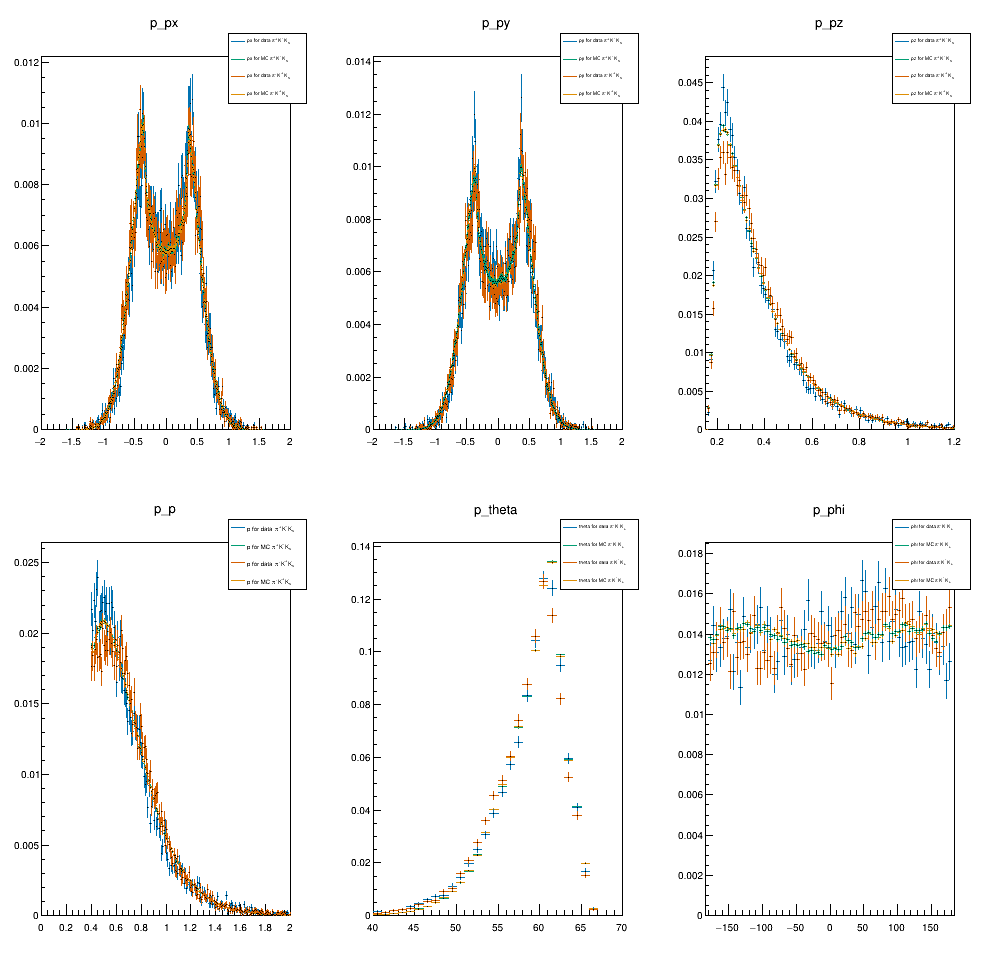

In [7]:
c = ROOT.TCanvas("c", "c", 1000, 1000)
c.Divide(3, 2)

proton_hists_pipkmks_data = get_kinematics('pipkmks', 'proton', df_pipkmks_data, pmin=0.0, pzmin=0.15, pzmax=1.2, thetamin=40.0, thetamax=70, phi_deg_per_bin=5.0)
proton_hists_pipkmks_signal = get_kinematics('pipkmks', 'proton', df_pipkmks_signal, pmin=0.0, pzmin=0.15, pzmax=1.2, thetamin=40.0, thetamax=70, phi_deg_per_bin=5.0)
proton_hists_pimkpks_data = get_kinematics('pimkpks', 'proton', df_pimkpks_data, pmin=0.0, pzmin=0.15, pzmax=1.2, thetamin=40.0, thetamax=70, phi_deg_per_bin=5.0)
proton_hists_pimkpks_signal = get_kinematics('pimkpks', 'proton', df_pimkpks_signal, pmin=0.0, pzmin=0.15, pzmax=1.2, thetamin=40.0, thetamax=70, phi_deg_per_bin=5.0)
legends = []
for i, hist_pipkmks_data in enumerate(proton_hists_pipkmks_data):
    c.cd(i+1)
    hist_pipkmks_data = hist_pipkmks_data.GetValue()
    hist_pimkpks_data = proton_hists_pimkpks_data[i].GetValue()
    hist_pimkpks_signal = proton_hists_pimkpks_signal[i].GetValue()
    hist_pipkmks_signal = proton_hists_pipkmks_signal[i].GetValue()
    quantity = hist_pimkpks_data.GetName().split('_')[1]
    hist_pimkpks_data.SetTitle(quantity + ' for p')
    hist_pimkpks_data.SetLineColor(ROOT.TColor.GetColor(constants.COLORBLIND_HEX_DICT['red']))
    hist_pipkmks_data.SetLineColor(ROOT.TColor.GetColor(constants.COLORBLIND_HEX_DICT['blue']))
    hist_pimkpks_signal.SetLineColor(ROOT.TColor.GetColor(constants.COLORBLIND_HEX_DICT['orange']))
    hist_pipkmks_signal.SetLineColor(ROOT.TColor.GetColor(constants.COLORBLIND_HEX_DICT['green']))
    hist_pipkmks_data.Scale(1.0/hist_pipkmks_data.Integral())
    hist_pipkmks_signal.Scale(1.0/hist_pipkmks_signal.Integral())
    hist_pimkpks_data.Scale(1.0/hist_pimkpks_data.Integral())
    hist_pimkpks_signal.Scale(1.0/hist_pimkpks_signal.Integral())
    legend = ROOT.TLegend(0.7, 0.8, 0.95, 0.95)
    label_pipkmks_data = quantity + ' for data #pi^{+}K^{-}K_{s}'
    label_pipkmks_signal = quantity + ' for MC #pi^{+}K^{-}K_{s}'
    label_pimkpks_data = quantity + ' for data #pi^{-}K^{+}K_{s}'
    label_pimkpks_signal = quantity + ' for MC #pi^{-}K^{+}K_{s}'
    legend.AddEntry(hist_pipkmks_data, label_pipkmks_data, 'l')
    legend.AddEntry(hist_pipkmks_signal, label_pipkmks_signal, 'l')
    legend.AddEntry(hist_pimkpks_data, label_pimkpks_data, 'l')
    legend.AddEntry(hist_pimkpks_signal, label_pimkpks_signal, 'l')
    legends.append(legend)
    sorted_hists = sort_hists_by_max([hist_pipkmks_data, hist_pimkpks_data, hist_pipkmks_signal, hist_pimkpks_signal])
    sorted_hists[0].Draw()
    for hist in sorted_hists[1:]:
        hist.Draw('same')
    legends[i].Draw()
c.Draw()

### Kaon Kinematics

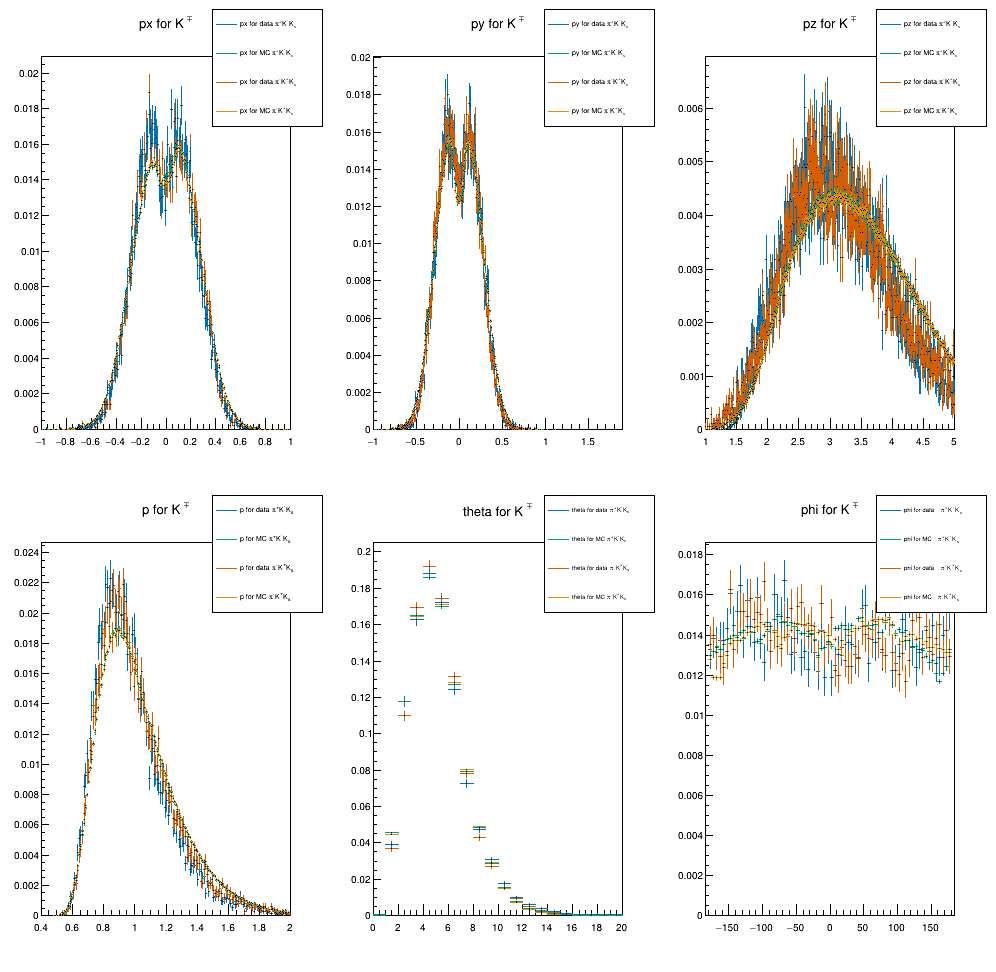

In [8]:
kaon_hists_pipkmks_data = get_kinematics('pipkmks', 'kaon', df_pipkmks_data, pmin=0.4, pzmin=1.0, pzmax=5.0, pxmin=-1.0, pxmax=1.0, pymin=-1.0, pymax=1.9, thetamin=0.0, thetamax=20, phi_deg_per_bin=5.0)
kaon_hists_pipkmks_signal = get_kinematics('pipkmks', 'kaon', df_pipkmks_signal, pmin=0.4, pzmin=1.0, pzmax=5.0, pxmin=-1.0, pxmax=1.0, pymin=-1.0, pymax=1.9, thetamin=0.0, thetamax=20, phi_deg_per_bin=5.0)
kaon_hists_pimkpks_data = get_kinematics('pimkpks', 'kaon', df_pimkpks_data, pmin=0.4, pzmin=1.0, pzmax=5.0, pxmin=-1.0, pxmax=1.0, pymin=-1.0, pymax=1.9, thetamin=0.0, thetamax=20, phi_deg_per_bin=5.0)
kaon_hists_pimkpks_signal = get_kinematics('pimkpks', 'kaon', df_pimkpks_signal, pmin=0.4, pzmin=1.0, pzmax=5.0, pxmin=-1.0, pxmax=1.0, pymin=-1.0, pymax=1.9, thetamin=0.0, thetamax=20, phi_deg_per_bin=5.0)
legends = []
for i, hist_pipkmks_data in enumerate(kaon_hists_pipkmks_data):
    c.cd(i+1)
    hist_pipkmks_data = hist_pipkmks_data.GetValue()
    hist_pimkpks_data = kaon_hists_pimkpks_data[i].GetValue()
    hist_pimkpks_signal = kaon_hists_pimkpks_signal[i].GetValue()
    hist_pipkmks_signal = kaon_hists_pipkmks_signal[i].GetValue()
    quantity = hist_pimkpks_data.GetName().split('_')[1]
    hist_pimkpks_data.SetTitle(quantity + ' for K^{#mp}')
    hist_pipkmks_data.SetTitle(quantity + ' for K^{#mp}')
    hist_pimkpks_signal.SetTitle(quantity + ' for K^{#mp}')
    hist_pipkmks_signal.SetTitle(quantity + ' for K^{#mp}')
    hist_pimkpks_data.SetLineColor(ROOT.TColor.GetColor(constants.COLORBLIND_HEX_DICT['red']))
    hist_pipkmks_data.SetLineColor(ROOT.TColor.GetColor(constants.COLORBLIND_HEX_DICT['blue']))
    hist_pimkpks_signal.SetLineColor(ROOT.TColor.GetColor(constants.COLORBLIND_HEX_DICT['orange']))
    hist_pipkmks_signal.SetLineColor(ROOT.TColor.GetColor(constants.COLORBLIND_HEX_DICT['green']))
    hist_pipkmks_data.Scale(1.0/hist_pipkmks_data.Integral())
    hist_pipkmks_signal.Scale(1.0/hist_pipkmks_signal.Integral())
    hist_pimkpks_data.Scale(1.0/hist_pimkpks_data.Integral())
    hist_pimkpks_signal.Scale(1.0/hist_pimkpks_signal.Integral())
    legend = ROOT.TLegend(0.65, 0.75, 1.0, 1.0)
    label_pipkmks_data = quantity + ' for data #pi^{+}K^{-}K_{s}'
    label_pipkmks_signal = quantity + ' for MC #pi^{+}K^{-}K_{s}'
    label_pimkpks_data = quantity + ' for data #pi^{-}K^{+}K_{s}'
    label_pimkpks_signal = quantity + ' for MC #pi^{-}K^{+}K_{s}'
    legend.AddEntry(hist_pipkmks_data, label_pipkmks_data, 'l')
    legend.AddEntry(hist_pipkmks_signal, label_pipkmks_signal, 'l')
    legend.AddEntry(hist_pimkpks_data, label_pimkpks_data, 'l')
    legend.AddEntry(hist_pimkpks_signal, label_pimkpks_signal, 'l')
    legends.append(legend)
    sorted_hists = sort_hists_by_max([hist_pipkmks_data, hist_pimkpks_data, hist_pipkmks_signal, hist_pimkpks_signal])
    sorted_hists[0].Draw()
    for hist in sorted_hists[1:]:
        hist.Draw('same')
    legends[i].Draw()
c.Draw()

### Pion Kinematics

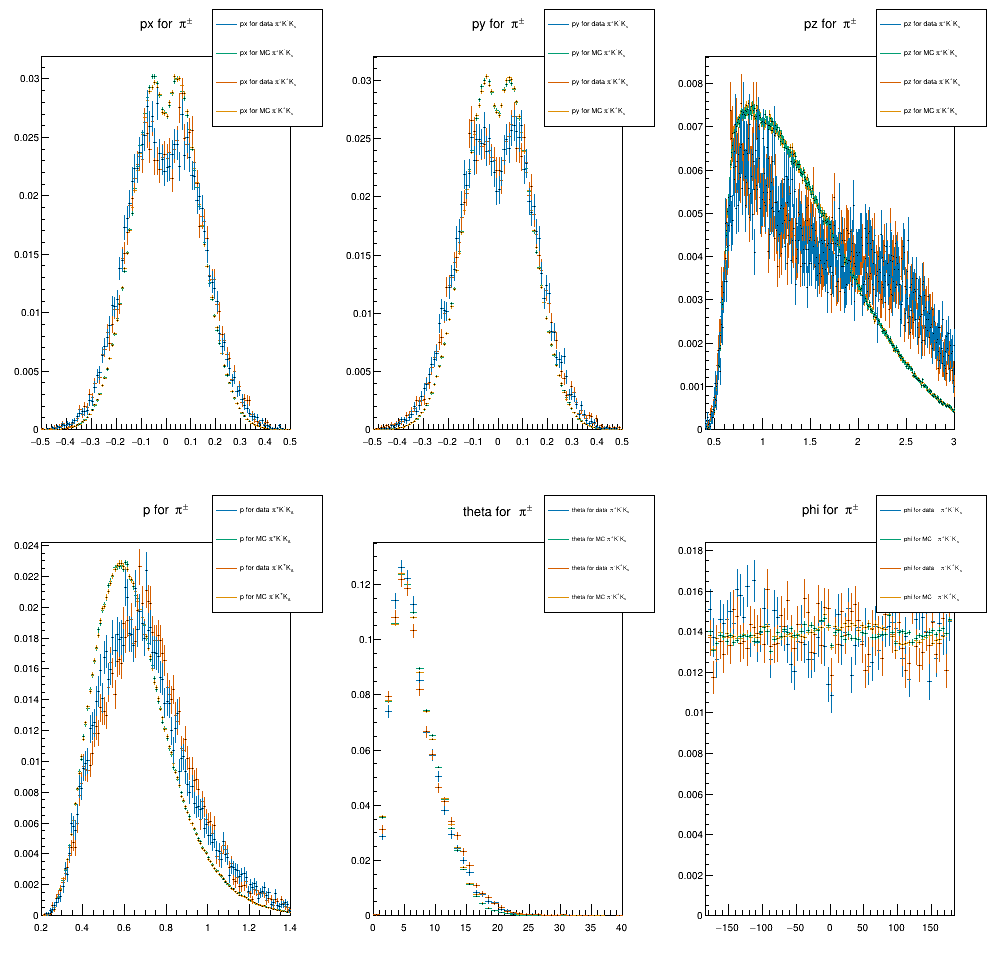

In [9]:
pion_hists_pipkmks_data = get_kinematics('pipkmks', 'pion', df_pipkmks_data, pmin=0.2, pmax=1.4,pxmin=-0.5, pxmax=0.5, pymin=-0.5, pymax=0.5, pzmin=0.4, pzmax=3.0, thetamin=0.0, thetamax=40, phi_deg_per_bin=5.0)
pion_hists_pipkmks_signal = get_kinematics('pipkmks', 'pion', df_pipkmks_signal, pmin=0.2, pmax=1.4,pxmin=-0.5, pxmax=0.5, pymin=-0.5, pymax=0.5, pzmin=0.4, pzmax=3.0, thetamin=0.0, thetamax=40, phi_deg_per_bin=5.0)
pion_hists_pimkpks_data = get_kinematics('pimkpks', 'pion', df_pimkpks_data, pmin=0.2, pmax=1.4,pxmin=-0.5, pxmax=0.5, pymin=-0.5, pymax=0.5, pzmin=0.4, pzmax=3.0, thetamin=0.0, thetamax=40, phi_deg_per_bin=5.0)
pion_hists_pimkpks_signal = get_kinematics('pimkpks', 'pion', df_pimkpks_signal, pmin=0.2, pmax=1.4,pxmin=-0.5, pxmax=0.5, pymin=-0.5, pymax=0.5, pzmin=0.4, pzmax=3.0, thetamin=0.0, thetamax=40, phi_deg_per_bin=5.0)
legends = []
for i, hist_pipkmks_data in enumerate(pion_hists_pipkmks_data):
    c.cd(i+1)
    hist_pipkmks_data = hist_pipkmks_data.GetValue()
    hist_pimkpks_data = pion_hists_pimkpks_data[i].GetValue()
    hist_pimkpks_signal = pion_hists_pimkpks_signal[i].GetValue()
    hist_pipkmks_signal = pion_hists_pipkmks_signal[i].GetValue()
    quantity = hist_pimkpks_data.GetName().split('_')[1]
    hist_pimkpks_data.SetTitle(quantity + ' for #pi^{#pm}')
    hist_pipkmks_data.SetTitle(quantity + ' for #pi^{#pm}')
    hist_pimkpks_signal.SetTitle(quantity + ' for #pi^{#pm}')
    hist_pipkmks_signal.SetTitle(quantity + ' for #pi^{#pm}')
    hist_pimkpks_data.SetLineColor(ROOT.TColor.GetColor(constants.COLORBLIND_HEX_DICT['red']))
    hist_pipkmks_data.SetLineColor(ROOT.TColor.GetColor(constants.COLORBLIND_HEX_DICT['blue']))
    hist_pimkpks_signal.SetLineColor(ROOT.TColor.GetColor(constants.COLORBLIND_HEX_DICT['orange']))
    hist_pipkmks_signal.SetLineColor(ROOT.TColor.GetColor(constants.COLORBLIND_HEX_DICT['green']))
    hist_pipkmks_data.Scale(1.0/hist_pipkmks_data.Integral())
    hist_pipkmks_signal.Scale(1.0/hist_pipkmks_signal.Integral())
    hist_pimkpks_data.Scale(1.0/hist_pimkpks_data.Integral())
    hist_pimkpks_signal.Scale(1.0/hist_pimkpks_signal.Integral())
    legend = ROOT.TLegend(0.65, 0.75, 1.0, 1.0)
    label_pipkmks_data = quantity + ' for data #pi^{+}K^{-}K_{s}'
    label_pipkmks_signal = quantity + ' for MC #pi^{+}K^{-}K_{s}'
    label_pimkpks_data = quantity + ' for data #pi^{-}K^{+}K_{s}'
    label_pimkpks_signal = quantity + ' for MC #pi^{-}K^{+}K_{s}'
    legend.AddEntry(hist_pipkmks_data, label_pipkmks_data, 'l')
    legend.AddEntry(hist_pipkmks_signal, label_pipkmks_signal, 'l')
    legend.AddEntry(hist_pimkpks_data, label_pimkpks_data, 'l')
    legend.AddEntry(hist_pimkpks_signal, label_pimkpks_signal, 'l')
    legends.append(legend)
    sorted_hists = sort_hists_by_max([hist_pipkmks_data, hist_pimkpks_data, hist_pipkmks_signal, hist_pimkpks_signal])
    sorted_hists[0].Draw()
    for hist in sorted_hists[1:]:
        hist.Draw('same')
    legends[i].Draw()
c.Draw()

### KShort Pi+ Kinematics

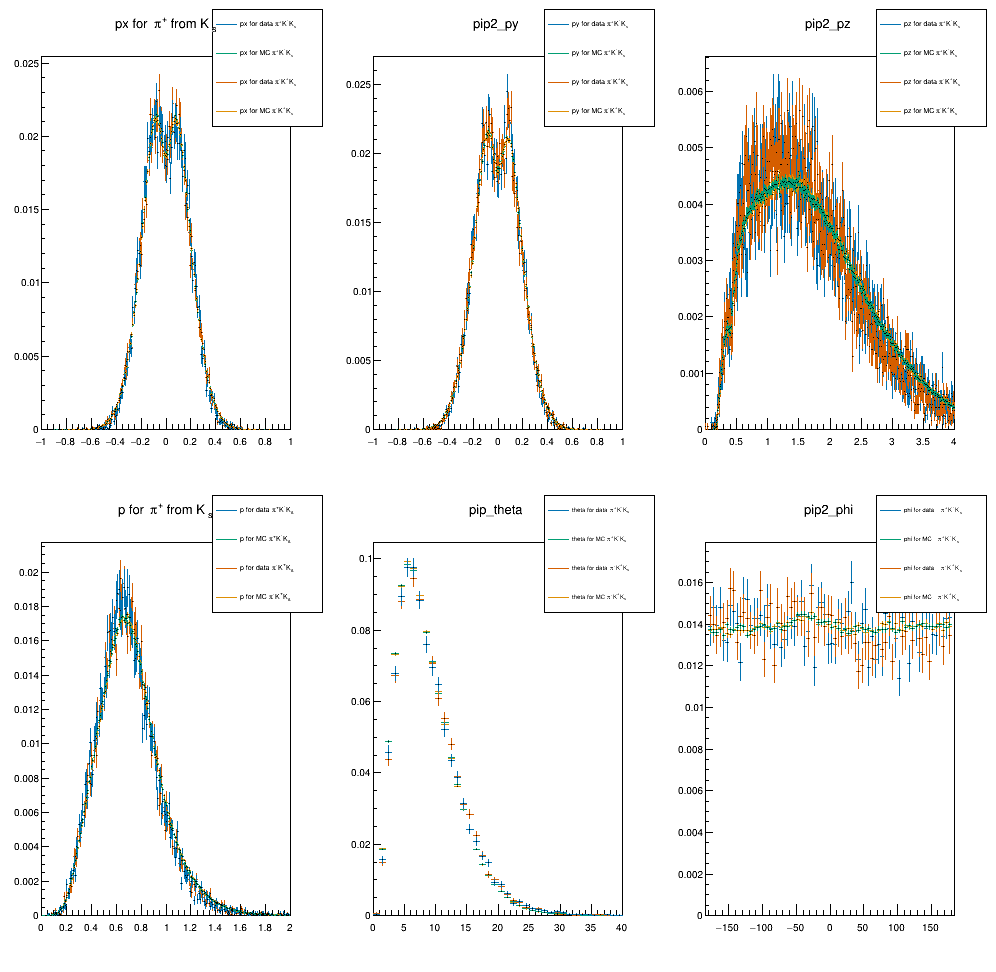

In [10]:
kspip_hists_pipkmks_data = get_kinematics('pipkmks', 'kshort_pi+', df_pipkmks_data, pmin=0.0, pzmin=0.0, pzmax=4.0, pxmin=-1.0, pxmax=1.0, pymin=-1.0, pymax=1.0, thetamin=0.0, thetamax=40, phi_deg_per_bin=5.0)
kspip_hists_pipkmks_signal = get_kinematics('pipkmks', 'kshort_pi+', df_pipkmks_signal, pmin=0.0, pzmin=0.0, pzmax=4.0, pxmin=-1.0, pxmax=1.0, pymin=-1.0, pymax=1.0, thetamin=0.0, thetamax=40, phi_deg_per_bin=5.0)
kspip_hists_pimkpks_data = get_kinematics('pimkpks', 'kshort_pi+', df_pimkpks_data, pmin=0.0, pzmin=0.0, pzmax=4.0, pxmin=-1.0, pxmax=1.0, pymin=-1.0, pymax=1.0, thetamin=0.0, thetamax=40, phi_deg_per_bin=5.0)
kspip_hists_pimkpks_signal = get_kinematics('pimkpks', 'kshort_pi+', df_pimkpks_signal, pmin=0.0, pzmin=0.0, pzmax=4.0, pxmin=-1.0, pxmax=1.0, pymin=-1.0, pymax=1.0, thetamin=0.0, thetamax=40, phi_deg_per_bin=5.0)
legends = []
for i, hist_pipkmks_data in enumerate(kspip_hists_pipkmks_data):
    c.cd(i+1)
    hist_pipkmks_data = hist_pipkmks_data.GetValue()
    hist_pimkpks_data = kspip_hists_pimkpks_data[i].GetValue()
    hist_pimkpks_signal = kspip_hists_pimkpks_signal[i].GetValue()
    hist_pipkmks_signal = kspip_hists_pipkmks_signal[i].GetValue()
    quantity = hist_pimkpks_data.GetName().split('_')[1]
    hist_pimkpks_data.SetTitle(quantity + ' for #pi^{+} from K_{s}')
    hist_pimkpks_data.SetLineColor(ROOT.TColor.GetColor(constants.COLORBLIND_HEX_DICT['red']))
    hist_pipkmks_data.SetLineColor(ROOT.TColor.GetColor(constants.COLORBLIND_HEX_DICT['blue']))
    hist_pimkpks_signal.SetLineColor(ROOT.TColor.GetColor(constants.COLORBLIND_HEX_DICT['orange']))
    hist_pipkmks_signal.SetLineColor(ROOT.TColor.GetColor(constants.COLORBLIND_HEX_DICT['green']))
    hist_pipkmks_data.Scale(1.0/hist_pipkmks_data.Integral())
    hist_pipkmks_signal.Scale(1.0/hist_pipkmks_signal.Integral())
    hist_pimkpks_data.Scale(1.0/hist_pimkpks_data.Integral())
    hist_pimkpks_signal.Scale(1.0/hist_pimkpks_signal.Integral())
    legend = ROOT.TLegend(0.65, 0.75, 1.0, 1.0)
    label_pipkmks_data = quantity + ' for data #pi^{+}K^{-}K_{s}'
    label_pipkmks_signal = quantity + ' for MC #pi^{+}K^{-}K_{s}'
    label_pimkpks_data = quantity + ' for data #pi^{-}K^{+}K_{s}'
    label_pimkpks_signal = quantity + ' for MC #pi^{-}K^{+}K_{s}'
    legend.AddEntry(hist_pipkmks_data, label_pipkmks_data, 'l')
    legend.AddEntry(hist_pipkmks_signal, label_pipkmks_signal, 'l')
    legend.AddEntry(hist_pimkpks_data, label_pimkpks_data, 'l')
    legend.AddEntry(hist_pimkpks_signal, label_pimkpks_signal, 'l')
    legends.append(legend)
    sorted_hists = sort_hists_by_max([hist_pipkmks_data, hist_pimkpks_data, hist_pipkmks_signal, hist_pimkpks_signal])
    sorted_hists[0].Draw()
    for hist in sorted_hists[1:]:
        hist.Draw('same')
    legends[i].Draw()
c.Draw()

### KShort Pi- Kinematics

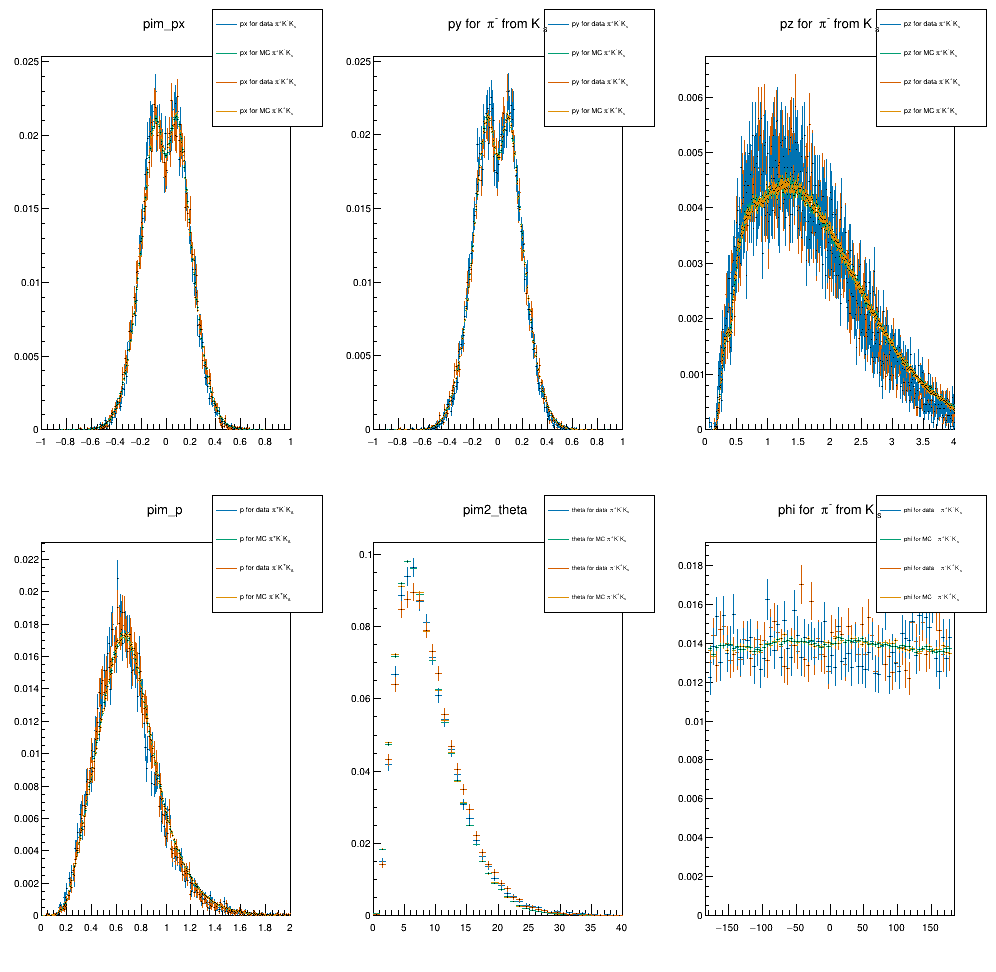

In [11]:

kspim_hists_pipkmks_data = get_kinematics('pipkmks', 'kshort_pi-', df_pipkmks_data, pmin=0.0, pzmin=0.0, pzmax=4.0, pxmin=-1.0, pxmax=1.0, pymin=-1.0, pymax=1.0, thetamin=0.0, thetamax=40, phi_deg_per_bin=5.0)
kspim_hists_pipkmks_signal = get_kinematics('pipkmks', 'kshort_pi-', df_pipkmks_signal, pmin=0.0, pzmin=0.0, pzmax=4.0, pxmin=-1.0, pxmax=1.0, pymin=-1.0, pymax=1.0, thetamin=0.0, thetamax=40, phi_deg_per_bin=5.0)
kspim_hists_pimkpks_data = get_kinematics('pimkpks', 'kshort_pi-', df_pimkpks_data, pmin=0.0, pzmin=0.0, pzmax=4.0, pxmin=-1.0, pxmax=1.0, pymin=-1.0, pymax=1.0, thetamin=0.0, thetamax=40, phi_deg_per_bin=5.0)
kspim_hists_pimkpks_signal = get_kinematics('pimkpks', 'kshort_pi-', df_pimkpks_signal, pmin=0.0, pzmin=0.0, pzmax=4.0, pxmin=-1.0, pxmax=1.0, pymin=-1.0, pymax=1.0, thetamin=0.0, thetamax=40, phi_deg_per_bin=5.0)
legends = []
for i, hist_pipkmks_data in enumerate(kspim_hists_pipkmks_data):
    c.cd(i+1)
    hist_pipkmks_data = hist_pipkmks_data.GetValue()
    hist_pimkpks_data = kspim_hists_pimkpks_data[i].GetValue()
    hist_pimkpks_signal = kspim_hists_pimkpks_signal[i].GetValue()
    hist_pipkmks_signal = kspim_hists_pipkmks_signal[i].GetValue()
    quantity = hist_pimkpks_data.GetName().split('_')[1]
    hist_pimkpks_data.SetTitle(quantity + ' for #pi^{-} from K_{s}')
    hist_pimkpks_data.SetLineColor(ROOT.TColor.GetColor(constants.COLORBLIND_HEX_DICT['red']))
    hist_pipkmks_data.SetLineColor(ROOT.TColor.GetColor(constants.COLORBLIND_HEX_DICT['blue']))
    hist_pimkpks_signal.SetLineColor(ROOT.TColor.GetColor(constants.COLORBLIND_HEX_DICT['orange']))
    hist_pipkmks_signal.SetLineColor(ROOT.TColor.GetColor(constants.COLORBLIND_HEX_DICT['green']))
    hist_pipkmks_data.Scale(1.0/hist_pipkmks_data.Integral())
    hist_pipkmks_signal.Scale(1.0/hist_pipkmks_signal.Integral())
    hist_pimkpks_data.Scale(1.0/hist_pimkpks_data.Integral())
    hist_pimkpks_signal.Scale(1.0/hist_pimkpks_signal.Integral())
    legend = ROOT.TLegend(0.65, 0.75, 1.0, 1.0)
    label_pipkmks_data = quantity + ' for data #pi^{+}K^{-}K_{s}'
    label_pipkmks_signal = quantity + ' for MC #pi^{+}K^{-}K_{s}'
    label_pimkpks_data = quantity + ' for data #pi^{-}K^{+}K_{s}'
    label_pimkpks_signal = quantity + ' for MC #pi^{-}K^{+}K_{s}'
    legend.AddEntry(hist_pipkmks_data, label_pipkmks_data, 'l')
    legend.AddEntry(hist_pipkmks_signal, label_pipkmks_signal, 'l')
    legend.AddEntry(hist_pimkpks_data, label_pimkpks_data, 'l')
    legend.AddEntry(hist_pimkpks_signal, label_pimkpks_signal, 'l')
    legends.append(legend)
    sorted_hists = sort_hists_by_max([hist_pipkmks_data, hist_pimkpks_data, hist_pipkmks_signal, hist_pimkpks_signal])
    sorted_hists[0].Draw()
    for hist in sorted_hists[1:]:
        hist.Draw('same')
    legends[i].Draw()
c.Draw()